# Modeling Demand for Analysis

**Target variable**: `Proj_TRN_RoomsPickup`: How many transient rooms will be booked for each stay date, from this point (8/1/17) forward, at current prices?

In [1]:
import pandas as pd
import numpy as np
import re
import datetime as dt
from agg import prep_demand_features
from demand_features import rf_cols

pd.options.display.max_rows = 162
pd.options.display.max_columns = 250
pd.options.display.max_colwidth = None

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

DATE_FMT = "%Y-%m-%d"
as_of_date = "2017-08-01"

print(__doc__)

Automatically created module for IPython interactive environment


In [2]:
date_cols = ['StayDate',
 'STLY_StayDate',
 'AsOfDate',
 'STLY_AsOfDate',
 'AsOfDate_STLY',
 'StayDate_STLY']

h1_stats = pd.read_csv("../data/h1_stats.csv", parse_dates=date_cols, infer_datetime_format=True)
h1_stats.drop(columns=["STLY_Stay_Date", "STLY_AsOfDate", "Unnamed: 0"], errors='ignore', inplace=True) # remove dup. columns


In [3]:
h1_stats.head()

,id,DOW,RoomsOTB,RevOTB,CxlForecast,TRN_RoomsOTB,TRN_RevOTB,TRN_CxlForecast,TRNP_RoomsOTB,GRP_RoomsOTB,CNT_RoomsOTB,StayDate,STLY_StayDate,DaysUntilArrival,Realized_Cxls,SellingPrice,TM30_RoomsOTB,TM30_RevOTB,TM30_TRN_RoomsOTB,TM30_TRN_RevOTB,TM15_RoomsOTB,TM15_RevOTB,TM15_TRN_RoomsOTB,TM15_TRN_RevOTB,TM05_RoomsOTB,TM05_RevOTB,TM05_TRN_RoomsOTB,TM05_TRN_RevOTB,AsOfDate,RemSupply,ADR_OTB,TRN_ADR_OTB,LYA_RoomsSold,LYA_ADR,LYA_RoomRev,LYA_NumCancels,LYA_TRN_RoomsSold,LYA_TRN_ADR,LYA_TRN_RoomRev,ACTUAL_RoomsSold,ACTUAL_ADR,ACTUAL_RoomRev,ACTUAL_TRN_RoomsSold,ACTUAL_TRN_ADR,ACTUAL_TRN_RoomRev,ACTUAL_NumCancels,ACTUAL_RoomsPickup,ACTUAL_ADR_Pickup,ACTUAL_RevPickup,ACTUAL_TRN_RoomsPickup,ACTUAL_TRN_ADR_Pickup,ACTUAL_TRN_RevPickup,MonthNum,DayOfWeek,Mon,Sat,Sun,Thu,Tue,Wed,WE,week_of_year,TM30_ADR_OTB,TM30_RoomsPickup,TM30_RevPickup,TM30_ADR_Pickup,TM30_TRN_ADR_OTB,TM30_TRN_RoomsPickup,TM30_TRN_RevPickup,TM30_TRN_ADR_Pickup,TM15_ADR_OTB,TM15_RoomsPickup,TM15_RevPickup,TM15_ADR_Pickup,TM15_TRN_ADR_OTB,TM15_TRN_RoomsPickup,TM15_TRN_RevPickup,TM15_TRN_ADR_Pickup,TM05_ADR_OTB,TM05_RoomsPickup,TM05_RevPickup,TM05_ADR_Pickup,TM05_TRN_ADR_OTB,TM05_TRN_RoomsPickup,TM05_TRN_RevPickup,TM05_TRN_ADR_Pickup,OTB_GapToLYA_RoomsSold,OTB_GapToLYA_ADR,OTB_GapToLYA_RoomRev,OTB_GapToLYA_NumCancels,OTB_GapToLYA_TRN_RoomsSold,OTB_GapToLYA_TRN_ADR,OTB_GapToLYA_TRN_RoomRev,id_STLY,AsOfDate_STLY,StayDate_STLY,RoomsOTB_STLY,ADR_OTB_STLY,RevOTB_STLY,ACTUAL_RoomsPickup_STLY,ACTUAL_ADR_Pickup_STLY,ACTUAL_RevPickup_STLY,CxlForecast_STLY,RemSupply_STLY,SellingPrice_STLY,Realized_Cxls_STLY,TRN_RoomsOTB_STLY,TRN_ADR_OTB_STLY,TRN_RevOTB_STLY,TRN_CxlForecast_STLY,ACTUAL_TRN_RoomsPickup_STLY,ACTUAL_TRN_ADR_Pickup_STLY,ACTUAL_TRN_RevPickup_STLY,TM30_RoomsPickup_STLY,TM30_ADR_Pickup_STLY,TM30_RevPickup_STLY,TM30_TRN_RoomsPickup_STLY,TM30_TRN_ADR_Pickup_STLY,TM30_TRN_RevPickup_STLY,TM15_RoomsPickup_STLY,TM15_ADR_Pickup_STLY,TM15_RevPickup_STLY,TM15_TRN_RoomsPickup_STLY,TM15_TRN_ADR_Pickup_STLY,TM15_TRN_RevPickup_STLY,TM05_RoomsPickup_STLY,TM05_ADR_Pickup_STLY,TM05_RevPickup_STLY,TM05_TRN_RoomsPickup_STLY,TM05_TRN_ADR_Pickup_STLY,TM05_TRN_RevPickup_STLY,Pace_RoomsOTB,Pace_ADR_OTB,Pace_RevOTB,Pace_CxlForecast,Pace_RemSupply,Pace_SellingPrice,Pace_TRN_RoomsOTB,Pace_TRN_ADR_OTB,Pace_TRN_RevOTB,Pace_TRN_CxlForecast,Pace_TM30_RoomsPickup,Pace_TM30_ADR_Pickup,Pace_TM30_RevPickup,Pace_TM30_TRN_RoomsPickup,Pace_TM30_TRN_ADR_Pickup,Pace_TM30_TRN_RevPickup,Pace_TM15_RoomsPickup,Pace_TM15_ADR_Pickup,Pace_TM15_RevPickup,Pace_TM15_TRN_RoomsPickup,Pace_TM15_TRN_ADR_Pickup,Pace_TM15_TRN_RevPickup,Pace_TM05_RoomsPickup,Pace_TM05_ADR_Pickup,Pace_TM05_RevPickup,Pace_TM05_TRN_RoomsPickup,Pace_TM05_TRN_ADR_Pickup,Pace_TM05_TRN_RevPickup
0,2016-07-31 - 2016-07-31,Sun,170.0,28570.36,25.0,137.0,23869.77,23.0,22.0,0.0,11.0,2016-07-31,2015-08-02,0.0,66.0,179.12,150.0,23981.92,122.0,20315.33,155.0,25254.01,127.0,21587.42,162.0,26749.13,128.0,21866.54,2016-07-31,42.0,168.06,174.23,168.0,144.92,24346.11,68.0,129.0,153.96,19860.51,170.0,168.06,28570.36,137.0,174.23,23869.77,66.0,0.0,0.00,0.00,0.0,0.00,0.00,7,Sun,False,False,1,False,False,False,False,30.0,159.88,20.0,4588.44,8.18,166.52,15.0,3554.44,7.71,162.93,15.0,3316.35,5.13,169.98,10.0,2282.35,4.25,165.12,8.0,1821.23,2.94,170.83,9.0,2003.23,3.40,-2.0,-23.14,-4224.25,2.0,-8.0,-20.27,-4009.26,2015-08-02 - 2015-08-02,2015-08-02,2015-08-02,168.0,144.92,24346.11,0.0,0.00,0.0,22.0,41.0,153.37,68.0,129.0,153.96,19860.51,21.0,0.0,0.00,0.0,7.0,4.16,1683.25,10.0,4.81,2111.23,7.0,2.54,1422.56,9.0,2.99,1743.54,6.0,1.37,1090.87,6.0,1.36,1090.87,2.0,23.14,4224.25,3.0,1.0,25.75,8.0,20.27,4009.26,2.0,13.0,4.02,2905.19,5.0,2.90,1443.21,8.0,2.59,1893.79,1.0,1.26,538.81,2.0,1.57,730.36,3.0,2.04,912.36
1,2016-07-31 - 2016-08-01,Mon,178.0,29525.52,31.0,148.0,25429.03,30.0,20.0,0.0,10.0,2016-08-01,2015-08-03,1.0,70.0,176.01,175.0,28404.00,145.0,24307.51,175.0,28536.80,145.0,24440.31,171.0,27933.34,141.0,23836.85,2016-07-31,40.0,165.87,171.82,178.0,149.32,26579.60,54.0,1

In [4]:
len(rf_cols)

40

## Splitting Up Our Data for Train/Test

For a Revenue Management application:
* Our training set will contain all dates prior to as_of_date.
* Our testing set will contain 31 stay dates starting on as_of_date. Our predictions will be used to provide price recommendations later on.

In [5]:
# method for application

mask = (h1_stats["StayDate"] < as_of_date)
test_mask = (h1_stats['AsOfDate'] >= as_of_date)
df_train = h1_stats.loc[mask].copy()
df_test = h1_stats.loc[test_mask].copy()

X_train = df_train[rf_cols].copy()
X_test = df_test[rf_cols].copy()
y_train = df_train['ACTUAL_TRN_RoomsPickup'].copy()
y_test = df_test['ACTUAL_TRN_RoomsPickup'].copy()

## Final Model

Using the params generate in demand_model_selection

In [6]:
rf = RandomForestRegressor(n_estimators=550, n_jobs=-1, random_state=20)

rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.7434636356564817

In [7]:
# add predictions to h1_stats for futher analysis

mask = h1_stats["AsOfDate"] >= as_of_date
h1_stat_preds = h1_stats[mask].copy()


preds = rf.predict(X_test)
h1_stat_preds["DemandPrediction"] = preds.round(0)
h1_stat_preds.index = h1_stat_preds.id

In [8]:
h1_stat_preds.head()

,id,DOW,RoomsOTB,RevOTB,CxlForecast,TRN_RoomsOTB,TRN_RevOTB,TRN_CxlForecast,TRNP_RoomsOTB,GRP_RoomsOTB,CNT_RoomsOTB,StayDate,STLY_StayDate,DaysUntilArrival,Realized_Cxls,SellingPrice,TM30_RoomsOTB,TM30_RevOTB,TM30_TRN_RoomsOTB,TM30_TRN_RevOTB,TM15_RoomsOTB,TM15_RevOTB,TM15_TRN_RoomsOTB,TM15_TRN_RevOTB,TM05_RoomsOTB,TM05_RevOTB,TM05_TRN_RoomsOTB,TM05_TRN_RevOTB,AsOfDate,RemSupply,ADR_OTB,TRN_ADR_OTB,LYA_RoomsSold,LYA_ADR,LYA_RoomRev,LYA_NumCancels,LYA_TRN_RoomsSold,LYA_TRN_ADR,LYA_TRN_RoomRev,ACTUAL_RoomsSold,ACTUAL_ADR,ACTUAL_RoomRev,ACTUAL_TRN_RoomsSold,ACTUAL_TRN_ADR,ACTUAL_TRN_RoomRev,ACTUAL_NumCancels,ACTUAL_RoomsPickup,ACTUAL_ADR_Pickup,ACTUAL_RevPickup,ACTUAL_TRN_RoomsPickup,ACTUAL_TRN_ADR_Pickup,ACTUAL_TRN_RevPickup,MonthNum,DayOfWeek,Mon,Sat,Sun,Thu,Tue,Wed,WE,week_of_year,TM30_ADR_OTB,TM30_RoomsPickup,TM30_RevPickup,TM30_ADR_Pickup,TM30_TRN_ADR_OTB,TM30_TRN_RoomsPickup,TM30_TRN_RevPickup,TM30_TRN_ADR_Pickup,TM15_ADR_OTB,TM15_RoomsPickup,TM15_RevPickup,TM15_ADR_Pickup,TM15_TRN_ADR_OTB,TM15_TRN_RoomsPickup,TM15_TRN_RevPickup,TM15_TRN_ADR_Pickup,TM05_ADR_OTB,TM05_RoomsPickup,TM05_RevPickup,TM05_ADR_Pickup,TM05_TRN_ADR_OTB,TM05_TRN_RoomsPickup,TM05_TRN_RevPickup,TM05_TRN_ADR_Pickup,OTB_GapToLYA_RoomsSold,OTB_GapToLYA_ADR,OTB_GapToLYA_RoomRev,OTB_GapToLYA_NumCancels,OTB_GapToLYA_TRN_RoomsSold,OTB_GapToLYA_TRN_ADR,OTB_GapToLYA_TRN_RoomRev,id_STLY,AsOfDate_STLY,StayDate_STLY,RoomsOTB_STLY,ADR_OTB_STLY,RevOTB_STLY,ACTUAL_RoomsPickup_STLY,ACTUAL_ADR_Pickup_STLY,ACTUAL_RevPickup_STLY,CxlForecast_STLY,RemSupply_STLY,SellingPrice_STLY,Realized_Cxls_STLY,TRN_RoomsOTB_STLY,TRN_ADR_OTB_STLY,TRN_RevOTB_STLY,TRN_CxlForecast_STLY,ACTUAL_TRN_RoomsPickup_STLY,ACTUAL_TRN_ADR_Pickup_STLY,ACTUAL_TRN_RevPickup_STLY,TM30_RoomsPickup_STLY,TM30_ADR_Pickup_STLY,TM30_RevPickup_STLY,TM30_TRN_RoomsPickup_STLY,TM30_TRN_ADR_Pickup_STLY,TM30_TRN_RevPickup_STLY,TM15_RoomsPickup_STLY,TM15_ADR_Pickup_STLY,TM15_RevPickup_STLY,TM15_TRN_RoomsPickup_STLY,TM15_TRN_ADR_Pickup_STLY,TM15_TRN_RevPickup_STLY,TM05_RoomsPickup_STLY,TM05_ADR_Pickup_STLY,TM05_RevPickup_STLY,TM05_TRN_RoomsPickup_STLY,TM05_TRN_ADR_Pickup_STLY,TM05_TRN_RevPickup_STLY,Pace_RoomsOTB,Pace_ADR_OTB,Pace_RevOTB,Pace_CxlForecast,Pace_RemSupply,Pace_SellingPrice,Pace_TRN_RoomsOTB,Pace_TRN_ADR_OTB,Pace_TRN_RevOTB,Pace_TRN_CxlForecast,Pace_TM30_RoomsPickup,Pace_TM30_ADR_Pickup,Pace_TM30_RevPickup,Pace_TM30_TRN_RoomsPickup,Pace_TM30_TRN_ADR_Pickup,Pace_TM30_TRN_RevPickup,Pace_TM15_RoomsPickup,Pace_TM15_ADR_Pickup,Pace_TM15_RevPickup,Pace_TM15_TRN_RoomsPickup,Pace_TM15_TRN_ADR_Pickup,Pace_TM15_TRN_RevPickup,Pace_TM05_RoomsPickup,Pace_TM05_ADR_Pickup,Pace_TM05_RevPickup,Pace_TM05_TRN_RoomsPickup,Pace_TM05_TRN_ADR_Pickup,Pace_TM05_TRN_RevPickup,DemandPrediction
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-08-01 - 2017-08-01,2017-08-01 - 2017-08-01,Tue,184.0,35239.14,18.0,151.0,29935.72,16.0,13.0,2.0,18.0,2017-08-01,2016-08-02,0.0,134.0,204.00,170.0,31991.18,139.0,27227.18,180.0,34519.71,147.0,29216.29,177.0,33992.74,144.0,28689.32,2017-08-01,21.0,191.52,198.25,183.0,170.00,31110.89,81.0,159.0,175.03,27829.05,184.0,191.52,35239.14,151.0,198.25,29935.72,134.0,0.0,0.00,0.00,0.0,0.00,0.00,8,Tue,False,False,0,False,True,False,False,31.0,188.18,14.0,3247.96,3.34,195.88,12.0,2708.54,2.37,191.78,4.0,719.43,-0.26,198.75,4.0,719.43,-0.50,192.05,7.0,1246.40,-0.53,199.23,7.0,1246.40,-0.98,-1.0,-21.52,-4128.25,-53.0,8.0,-23.22,-2106.67,2016-08-02 - 2016-08-02,2016-08-02,2016-08-02,183.0,170.00,31110.89,0.0,0.00,0.00,39.0,43.0,178.09,81.0,159.0,175.03,27829.05,34.0,0.0,0.00,0.00,3.0,4.00,1230.63,3.0,4.53,1230.63,3.0,2.64,985.79,3.0,2.96,985.79,1.0,1.88,512.25,1.0,2.14,512.25,1.0,21.52,4128.25,-21.0,-22.0,25.91,-8.0,23.22,2106.67,-18.0,11.0,-0.66,2017.33,9.0,-2.16,1477.91,1.0,-2.90,-266.36,1.0,-3.46,-266.36,6.0,-2.41,734.15,6.0,-3.12,734.15,-1.0
2017-08-01 - 2017-08-02,2017-08-01 - 2017-08-02,We

In [9]:
display_cols = [
    "DOW",
    "RemSupply",
    "RemSupply_STLY",
    "OTB_GapToLYA_TRN_RoomsSold",
    "ACTUAL_TRN_RoomsPickup",
    "DemandPrediction"
]
h1_stat_preds[display_cols].head()

,DOW,RemSupply,RemSupply_STLY,OTB_GapToLYA_TRN_RoomsSold,ACTUAL_TRN_RoomsPickup,DemandPrediction
id,,,,,,
2017-08-01 - 2017-08-01,Tue,21.0,43.0,8.0,0.0,-1.0
2017-08-01 - 2017-08-02,Wed,21.0,50.0,8.0,0.0,-0.0
2017-08-01 - 2017-08-03,Thu,27.0,51.0,7.0,-7.0,0.0
2017-08-01 - 2017-08-04,Fri,25.0,50.0,-3.0,-6.0,-0.0
2017-08-01 - 2017-08-05,Sat,34.0,49.0,17.0,5.0,3.0


In [10]:
mean_absolute_error(y_test, preds)

2.3095014662756603

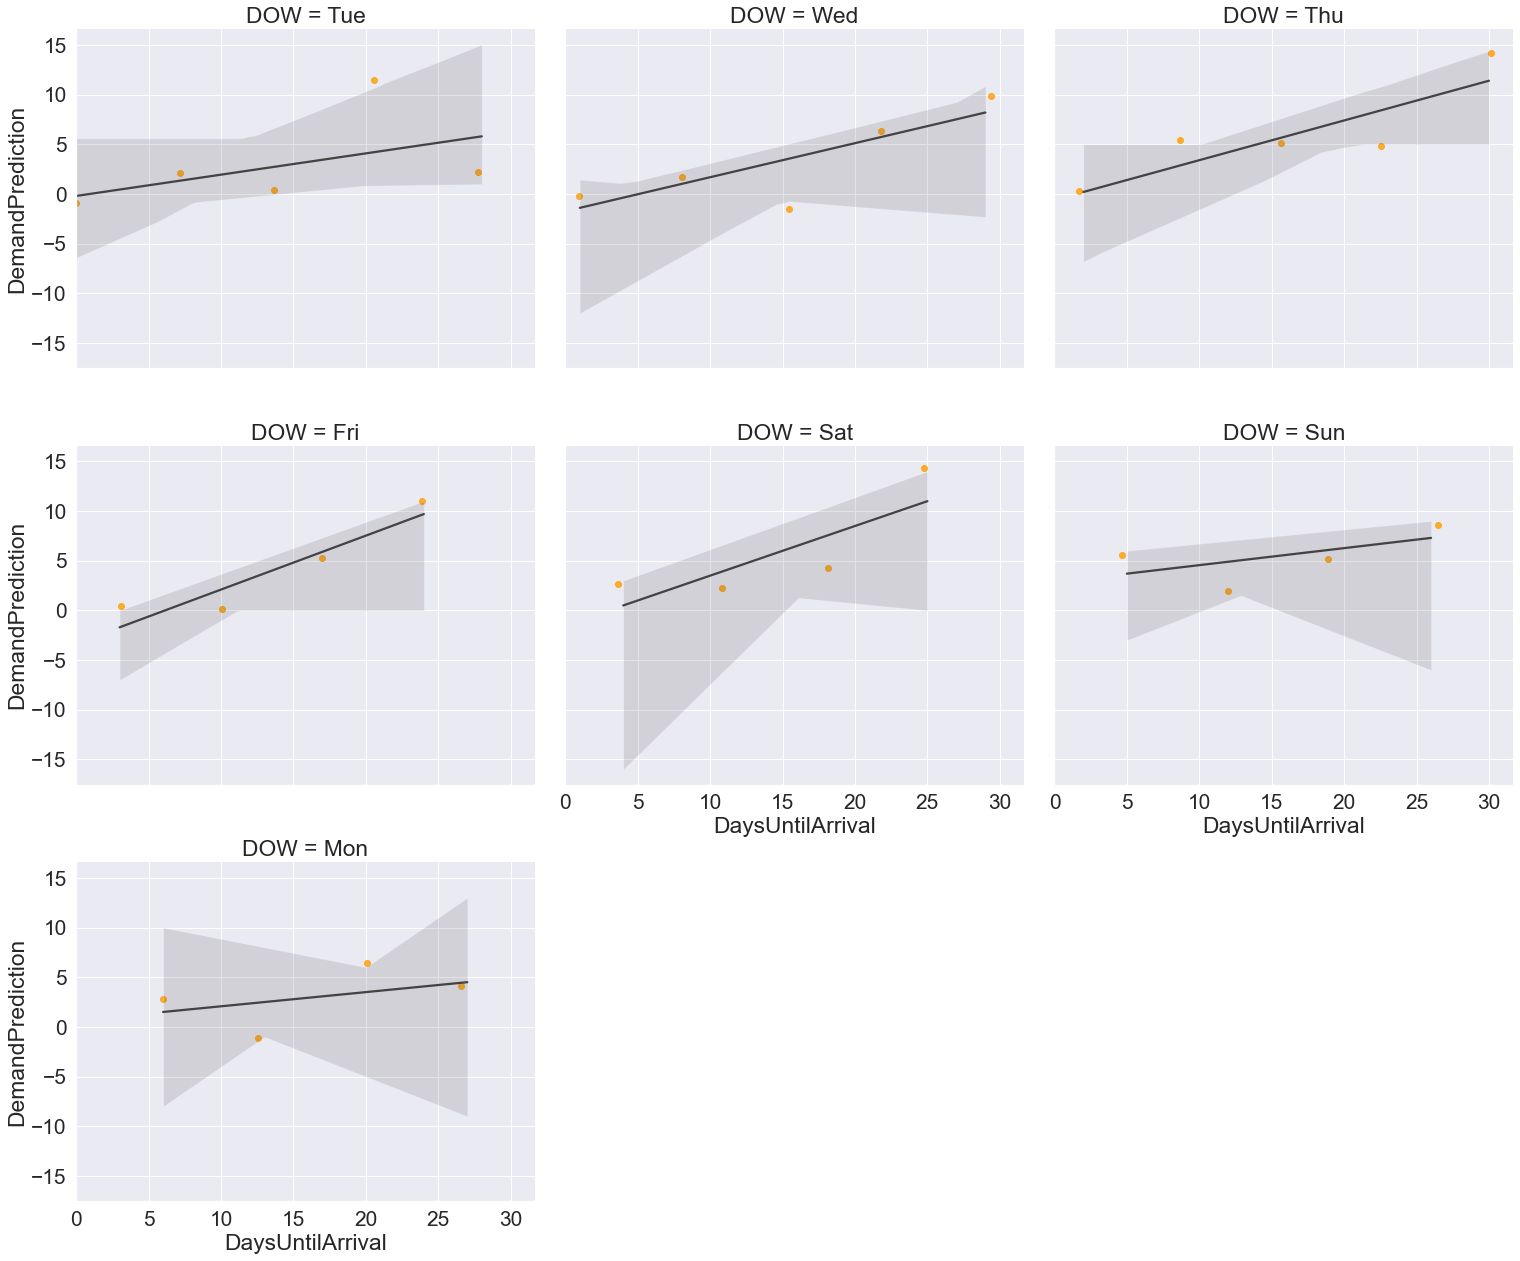

In [11]:
# plt.subplots(figsize=(14, 14))
title = "Outliers seem to pull line downwards further from arrival."
sns.set(font_scale=1.9)
ax = sns.lmplot(x="DaysUntilArrival", y="DemandPrediction", col='DOW', col_wrap=3, x_jitter=0.5, y_jitter=0.5, data=h1_stat_preds, height=6, aspect=1.2,
               scatter_kws={"color": "#ff9e00"}, line_kws={"color": "#434343"})

# title_font = {
#     "size": 18
# }

# label_font = {
#     "size": 16
# }
# plt.title(title, fontdict=title_font)
# plt.xlabel("Num Days Until Arrival", fontdict=label_font)
# plt.ylabel("Remaining Demand Prediction", fontdict=label_font)
plt.tight_layout()
plt.savefig("../etc/h1_lmplot_dow.jpeg", dpi=200)
plt.show()




In [12]:
# plt.subplots(figsize=(14, 14))
sns.set_theme("ggplot")
sns.set_style("white")
title = "Outliers seem to pull line downwards further from arrival."

ax = sns.lmplot(x="DaysUntilArrival", y="DemandPrediction", x_jitter=0.5, y_jitter=0.5, data=h1_stat_preds, height=6, aspect=1.2,
               scatter_kws={"color": "#ff9e00"}, line_kws={"color": "#434343"})

title_font = {
    "size": 18
}

label_font = {
    "size": 16
}

plt.title(title, fontdict=title_font)
plt.xlabel("Num Days Until Arrival", fontdict=label_font)
plt.ylabel("Remaining Demand Prediction", fontdict=label_font)
plt.tight_layout()
plt.savefig("../etc/h1_lmplot.jpeg", facecolor='none', dpi=200)
plt.show()

ValueError: context must be in paper, notebook, talk, poster

## Now that we have our model, let's get it in the simulation so we can evaluate our results.

Head over to `demand_model_evaluation.ipynb` for more.